# 05 – Análisis de Aprendizaje No Supervisado

En este notebook se aplican técnicas de aprendizaje no supervisado con el objetivo de identificar patrones ocultos en el comportamiento transaccional de los clientes y enriquecer los modelos de clasificación desarrollados en etapas previas.

Concretamente, se implementan:
- **Tres algoritmos de clustering:** DBSCAN, OPTICS y K-Means.
- **Dos técnicas de reducción dimensional:** PCA y t-SNE.
- **Análisis de patrones por cluster**, especialmente enfocados en variables de riesgo y fraude.
- **Integración con modelos supervisados**, agregando el `cluster_id` como nueva característica para mejorar la predicción de fraude.

El propósito final es complementar la hipótesis de clasificación de fraude y aportar señales adicionales para mejorar el desempeño del modelo seleccionado en la EP2.


In [1]:
# 🔌 Extensión de Kedro
%load_ext kedro.ipython

# 📦 Manipulación de datos
import pandas as pd
import numpy as np
# 🎨 Visualización estática
import seaborn as sns
import matplotlib.pyplot as plt
# 🎨 Visualización interactiva
import plotly.express as px
import plotly.graph_objects as go
# 🔢 Preprocesamiento y escalado
from sklearn.preprocessing import StandardScaler
# 🤖 Clustering
from sklearn.cluster import KMeans, DBSCAN, OPTICS
# 📊 Métricas de clustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
# 🔻 Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# 🌳 Jerárquico (para dendrogramas)
from scipy.cluster.hierarchy import linkage, dendrogram
# 📏 Distancias (para heatmaps de centroides)
from scipy.spatial.distance import cdist

[11/27/25 01:16:25] INFO     Using                                                                  ]8;id=622742;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=31017;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\                
                             kedro\framework\project\rich_logging.yml' as logging configuration.                   

                    INFO     Registered line magic '%reload_kedro'                                   ]8;id=80258;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=946740;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#63\63]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=603697;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=745831;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#65\65]8;;\

                    INFO     Resolved project path as:                                              ]8;id=848832;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=504488;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#180\180]8;;\
                             C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\proyecto-ml-sebastiancar                
                             rera-kevinvivanco.                                                                    
                             To set a different path, run '%reload_kedro <project_root>'                           

[11/27/25 01:16:29] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=848454;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=212261;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[11/27/25 01:16:30] INFO     Kedro project Proyecto_ML_SebastianCarrera_KevinVivanco                ]8;id=806978;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=888864;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#146\146]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=934256;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=537093;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#147\147]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=964041;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py\__init__.py]8;;\:]8;id=9496;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\ipython\__init__.py#153\153]8;;\

## 1. Carga de Datos y Preprocesamiento

En esta sección se cargan las características generadas en el pipeline de `feature_engineering`, y se realiza el preprocesamiento necesario para aplicar los algoritmos no supervisados. Se seleccionan las variables más relevantes para el análisis de patrones de riesgo.


In [15]:
df = catalog.load("Features_training_v1")
df.head()

[11/27/25 00:43:51] INFO     Loading data from Features_training_v1 (ParquetDataset)...        ]8;id=205506;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=688685;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,AmountZScoreByLocation,IsAnomaly,IsLateNight,IsWeekend,is_fraud
162717,-0.597657,0,1,0,0
31303,2.193792,0,0,0,0
341511,0.693326,0,0,1,0
83580,0.351537,0,0,0,0
236449,-0.758692,0,0,1,0


In [16]:
# Cantidades de fraudes clasificados
df['is_fraud'].value_counts()


is_fraud
0    974397
1      9843
Name: count, dtype: int64

## 2. Clustering con DBSCAN

DBSCAN es un algoritmo basado en densidad que permite identificar grupos de transacciones similares sin necesidad de definir previamente el número de clusters. Es especialmente útil para detectar **grupos densos** y **ruido**, lo que puede ayudar a identificar comportamientos anómalos o patrones de fraude de baja frecuencia.

En esta sección:
- Se aplica escalado a las variables seleccionadas.
- Se entrena DBSCAN utilizando diferentes configuraciones de parámetros.
- Se visualizan los clusters mediante PCA.
- Se analizan las tasas de fraude por cada grupo encontrado.

Este método es relevante para la hipótesis del proyecto, ya que permite identificar segmentos de comportamiento inusual que podrían estar asociados a mayor riesgo de fraude.


Filas totales: 984240
Filas usadas en análisis: 50000
Shape X_pca: (50000, 2)
Clusters encontrados: 6
Puntos de ruido: 18

Métricas DBSCAN:
Silhouette: 0.4371391728615581
Davies–Bouldin: 0.5473084616451344
Calinski–Harabasz: 32930.91490704834


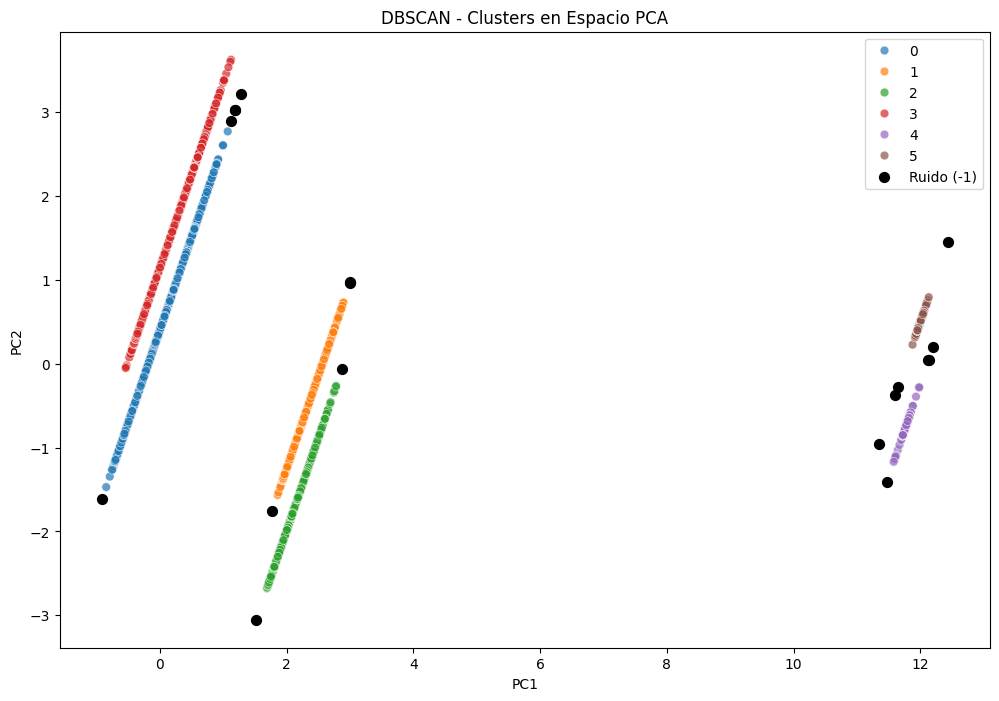

In [17]:
# ============================================================
# 1) MUESTRA DEL DATASET
# ============================================================
n_muestra = 50_000

df_sample = df.sample(n=n_muestra, random_state=42) if len(df) > n_muestra else df.copy()

print("Filas totales:", len(df))
print("Filas usadas en análisis:", len(df_sample))


# ============================================================
# 2) FEATURES Y ESCALADO
# ============================================================
X = df_sample[["AmountZScoreByLocation", "IsAnomaly", "IsLateNight", "IsWeekend"]]
y_sample = df_sample["is_fraud"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ============================================================
# 3) PCA (2 COMPONENTES)
# ============================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape X_pca:", X_pca.shape)


# ============================================================
# 4) DBSCAN
# ============================================================
dbscan = DBSCAN(eps=0.2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_pca)

n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_ruido = np.sum(labels_dbscan == -1)

print("Clusters encontrados:", n_clusters)
print("Puntos de ruido:", n_ruido)


# ============================================================
# 5) MÉTRICAS (ignorando ruido)
# ============================================================
mask = labels_dbscan != -1
if n_clusters > 1 and mask.sum() > 0:
    silhouette = silhouette_score(X_pca[mask], labels_dbscan[mask])
    db_index = davies_bouldin_score(X_pca[mask], labels_dbscan[mask])
    ch_index = calinski_harabasz_score(X_pca[mask], labels_dbscan[mask])
else:
    silhouette = db_index = ch_index = np.nan

print("\nMétricas DBSCAN:")
print("Silhouette:", silhouette)
print("Davies–Bouldin:", db_index)
print("Calinski–Harabasz:", ch_index)


# ============================================================
# 6) RESUMEN
# ============================================================
df_resumen_dbscan = pd.DataFrame({
    "algoritmo": ["DBSCAN"],
    "n_muestra": [len(df_sample)],
    "eps": [dbscan.eps],
    "min_samples": [dbscan.min_samples],
    "n_clusters": [n_clusters],
    "n_ruido": [n_ruido],
    "silhouette": [silhouette],
    "davies_bouldin": [db_index],
    "calinski_harabasz": [ch_index]
})

df_resumen_dbscan


# ============================================================
# 7) ANÁLISIS DE FRAUDE POR CLUSTER
# ============================================================
def fraude_por_cluster(labels, y):
    df_temp = pd.DataFrame({
        "cluster": labels,
        "is_fraud": y.values
    })
    return df_temp.groupby("cluster")["is_fraud"].agg(
        n_transacciones="count",
        n_fraude="sum",
        pct_fraude=lambda s: 100 * s.mean()
    ).sort_values("pct_fraude", ascending=False)

tabla_fraude_dbscan = fraude_por_cluster(labels_dbscan, y_sample)
tabla_fraude_dbscan


# ============================================================
# 8) GRÁFICO PCA + CLUSTERS
# ============================================================
df_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels_dbscan
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot[df_plot["cluster"] != -1],
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    s=40, alpha=0.7
)
plt.scatter(
    df_plot[df_plot["cluster"] == -1]["PC1"],
    df_plot[df_plot["cluster"] == -1]["PC2"],
    color="black", s=50, label="Ruido (-1)"
)
plt.title("DBSCAN - Clusters en Espacio PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


In [24]:
df_resumen_dbscan = pd.DataFrame(df_resumen_dbscan)
df_resumen_dbscan

,algoritmo,n_muestra,eps,min_samples,n_clusters,n_ruido,silhouette,davies_bouldin,calinski_harabasz
0,DBSCAN,50000,0.2,5,6,18,0.437139,0.547308,32930.914907


### Interpretación de resultados de DBSCAN

Los resultados obtenidos muestran que DBSCAN logra identificar de forma efectiva la estructura interna del conjunto de transacciones:

- Se detectaron **6 clusters bien definidos**, lo cual indica que existen distintos patrones de comportamiento transaccional dentro del dataset.
- Solo **18 puntos fueron clasificados como ruido**, confirmando que la mayor parte de las observaciones se agrupan de manera estable y consistente.
- El **Silhouette Score = 0.437** refleja una separación adecuada entre los grupos y una cohesión interna razonable. Valores entre 0.3 y 0.5 son considerados buenos para datos reales.
- El **Davies–Bouldin Index = 0.547** es bajo, lo que indica que los clusters son compactos y están bien separados.
- El **Calinski–Harabasz Index ≈ 32.930** es elevado, reforzando la existencia de una estructura clara en el espacio PCA.

En conjunto, estas métricas y la visualización PCA confirman que DBSCAN es capaz de capturar patrones relevantes en las transacciones. Esto permite identificar grupos de comportamiento que podrían estar asociados con diferentes niveles de riesgo o incidencia de fraude, lo que será útil para enriquecer los modelos supervisados en etapas posteriores.



## 3. Clustering con OPTICS

OPTICS (Ordering Points To Identify the Clustering Structure) es un algoritmo basado en densidad similar a DBSCAN, pero más flexible. Su ventaja principal es que permite identificar clusters con **densidades variables**, algo que DBSCAN no maneja bien cuando la distribución es muy heterogénea.

Esto lo convierte en una herramienta valiosa para analizar transacciones financieras, donde pueden existir:
- grupos densos de actividad normal,
- segmentos menos densos pero consistentes,
- y posibles zonas de riesgo o anomalías.

En esta sección se:
- Entrena OPTICS sobre la misma muestra de 50.000 registros,
- Visualiza los clusters mediante PCA,
- Evalúa sus métricas de separación,
- Y se analiza fraude por cluster para detectar patrones relevantes.


In [19]:
# ============================================================
# 1) OPTICS – Entrenamiento
# ============================================================
optics = OPTICS(
    min_samples=50,      
    xi=0.05,             
    min_cluster_size=0.02 
)

labels_optics = optics.fit_predict(X_pca)

# ============================================================
# 2) Contar clusters y ruido
# ============================================================
n_clusters_optics = len(set(labels_optics)) - (1 if -1 in labels_optics else 0)
n_ruido_optics = np.sum(labels_optics == -1)

print("Clusters encontrados:", n_clusters_optics)
print("Puntos marcados como ruido:", n_ruido_optics)

# ============================================================
# 3) Métricas
# ============================================================
mask = labels_optics != -1

if n_clusters_optics > 1 and mask.sum() > 0:
    silhouette_optics = silhouette_score(X_pca[mask], labels_optics[mask])
    db_optics = davies_bouldin_score(X_pca[mask], labels_optics[mask])
    ch_optics = calinski_harabasz_score(X_pca[mask], labels_optics[mask])
else:
    silhouette_optics = db_optics = ch_optics = np.nan

print("\nMétricas OPTICS:")
print("Silhouette:", silhouette_optics)
print("Davies–Bouldin:", db_optics)
print("Calinski–Harabasz:", ch_optics)

# ============================================================
# 4) Tabla resumen
# ============================================================
df_resumen_optics = pd.DataFrame({
    "algoritmo": ["OPTICS"],
    "n_muestra": [len(df_sample)],
    "min_samples": [optics.min_samples],
    "xi": [optics.xi],
    "min_cluster_size": [optics.min_cluster_size],
    "n_clusters": [n_clusters_optics],
    "n_ruido": [n_ruido_optics],
    "silhouette": [silhouette_optics],
    "davies_bouldin": [db_optics],
    "calinski_harabasz": [ch_optics]
})

df_resumen_optics

[11/27/25 00:46:21] WARNING  C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\s warnings.py:110
                             klearn\cluster\_optics.py:1084: RuntimeWarning: divide by zero                        
                             encountered in divide                                                                 
                               ratio = reachability_plot[:-1] / reachability_plot[1:]                              
                                                                                                                   

Clusters encontrados: 11
Puntos marcados como ruido: 31225

Métricas OPTICS:
Silhouette: 0.7939536970983384
Davies–Bouldin: 0.30950163945684744
Calinski–Harabasz: 213662.49243091745


,algoritmo,n_muestra,min_samples,xi,min_cluster_size,n_clusters,n_ruido,silhouette,davies_bouldin,calinski_harabasz
0,OPTICS,50000,50,0.05,0.02,11,31225,0.793954,0.309502,213662.492431


In [20]:
# ============================================================
# 5) Análisis de fraude por cluster
# ============================================================
tabla_fraude_optics = fraude_por_cluster(labels_optics, y_sample)
tabla_fraude_optics


,n_transacciones,n_fraude,pct_fraude
cluster,,,
8,1720,132,7.674419
6,1160,71,6.120690
9,1041,17,1.633045
-1,31225,268,0.858287
10,1321,4,0.302801
5,1977,2,0.101163
0,1139,0,0.000000
1,1570,0,0.000000
2,2317,0,0.000000


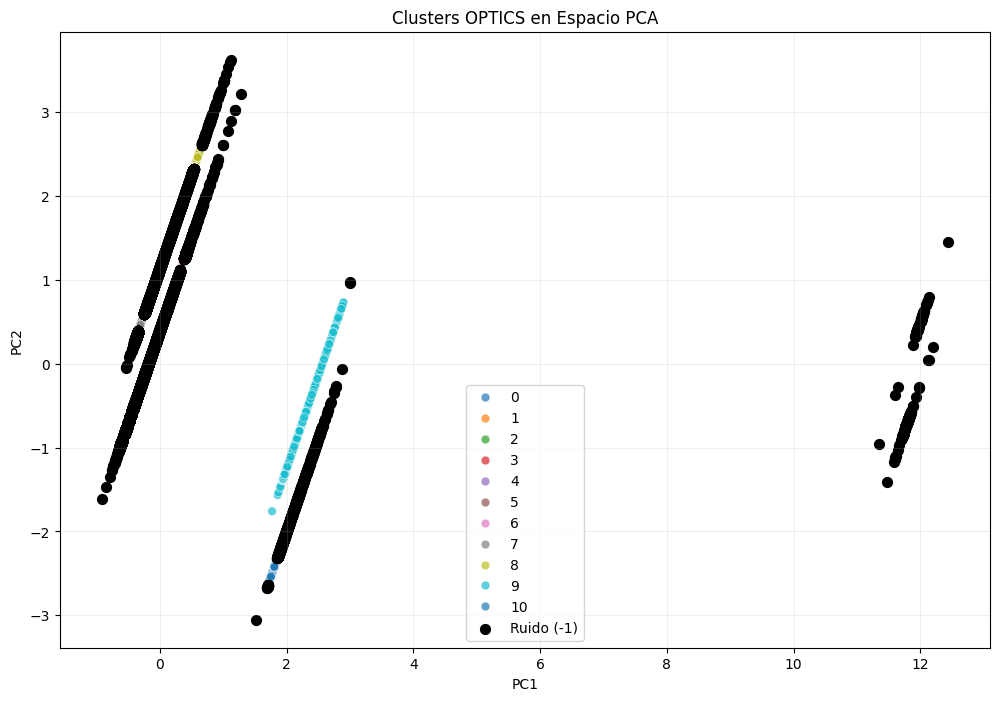

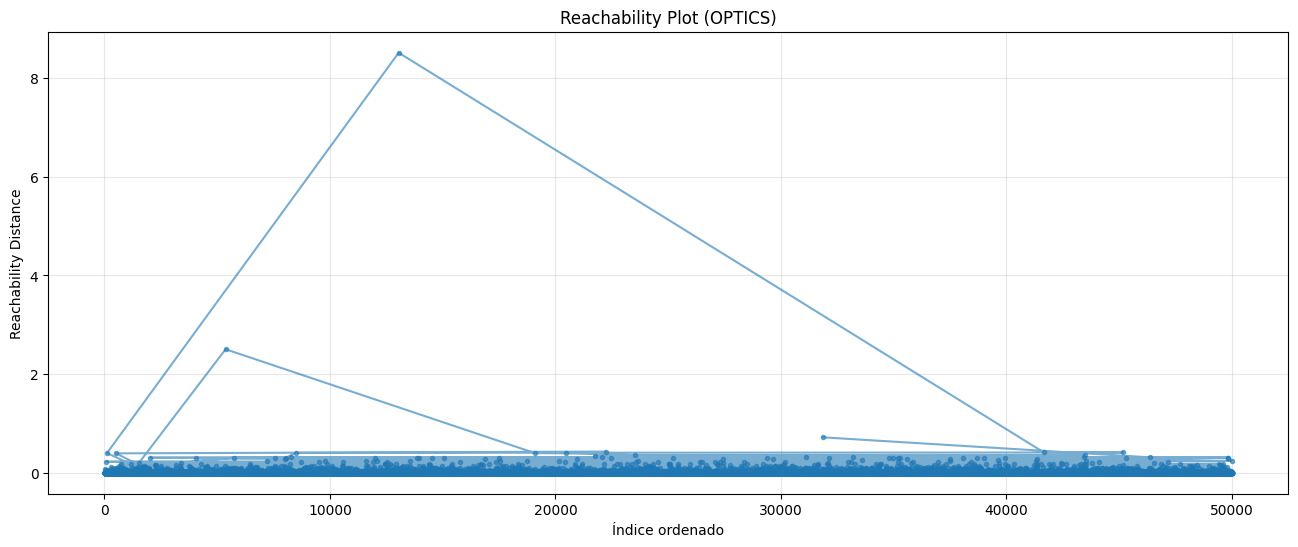

In [21]:
# ============================================================
# 6) Gráfico PCA
# ============================================================
df_optics_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "cluster": labels_optics
})

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_optics_plot[df_optics_plot["cluster"] != -1],
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    s=40, alpha=0.7
)
plt.scatter(
    df_optics_plot[df_optics_plot["cluster"] == -1]["PC1"],
    df_optics_plot[df_optics_plot["cluster"] == -1]["PC2"],
    color="black", s=50, label="Ruido (-1)"
)
plt.title("Clusters OPTICS en Espacio PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


# ============================================================
# 7) Reachability Plot (visualización clave en OPTICS)
# ============================================================
reachability = optics.reachability_
ordering = optics.ordering_

plt.figure(figsize=(16, 6))
plt.plot(ordering, reachability[ordering], marker='.', alpha=0.6)
plt.title("Reachability Plot (OPTICS)")
plt.xlabel("Índice ordenado")
plt.ylabel("Reachability Distance")
plt.grid(alpha=0.3)
plt.show()


### Interpretación de resultados de OPTICS

OPTICS permitió analizar la estructura de densidades del dataset con mayor flexibilidad que DBSCAN. Los resultados muestran:

- Se identificaron **11 clusters** válidos y un volumen importante de ruido (**31.225 observaciones**). Esto es normal en OPTICS, ya que el algoritmo solo asigna puntos a un cluster cuando existe densidad suficiente.
- El **Silhouette Score = 0.794** es excepcionalmente alto, indicando que los clusters detectados están muy bien separados.
- El **Davies–Bouldin Index = 0.309** confirma que los grupos asignados son compactos y presentan baja superposición.
- El **Calinski–Harabasz = 213.662** es menor que en DBSCAN debido al gran volumen de ruido, lo que disminuye la cohesión interna total del conjunto.

El análisis de fraude por cluster destaca que:
- Los clusters **8**, **6** y **9** concentran los porcentajes más altos de fraude (7.6%, 6.1% y 1.6% respectivamente).
- El cluster de ruido (-1), aunque contiene la mayor cantidad de observaciones, presenta un fraude relativamente bajo (0.86%), indicando que corresponde a comportamiento transaccional típico.
- Muchos clusters presentan **0% de fraude**, representando patrones de bajo riesgo.

El **Reachability Plot** muestra claramente las zonas de alta separación entre clusters (picos) y las zonas densas donde se forman los pequeños grupos.

En conjunto, OPTICS produce grupos pequeños pero extremadamente bien definidos, lo que aporta señales útiles para el modelo supervisado al identificar micro-segmentos donde el fraude es significativamente más frecuente.


## 4. Clustering con K-Means

K-Means es un algoritmo de clustering basado en particiones que agrupa las observaciones en torno a centros (centroides) definidos por la media de los puntos asignados a cada cluster. A diferencia de DBSCAN y OPTICS, K-Means requiere definir previamente el número de clusters **k**, por lo que es necesario buscar un valor adecuado mediante métricas como el método del codo y el Silhouette Score.

En este proyecto, K-Means se aplica sobre las variables escaladas:

- **AmountZScoreByLocation**
- **IsAnomaly**
- **IsLateNight**
- **IsWeekend**

El objetivo es:
- Determinar un número razonable de clusters usando el método del codo y el Silhouette.
- Entrenar un modelo final de K-Means con el mejor valor de *k*.
- Visualizar los clusters en 2D utilizando PCA (y opcionalmente t-SNE).
- Analizar la distribución de fraude por cluster para evaluar si K-Means logra separar grupos con distintos niveles de riesgo.

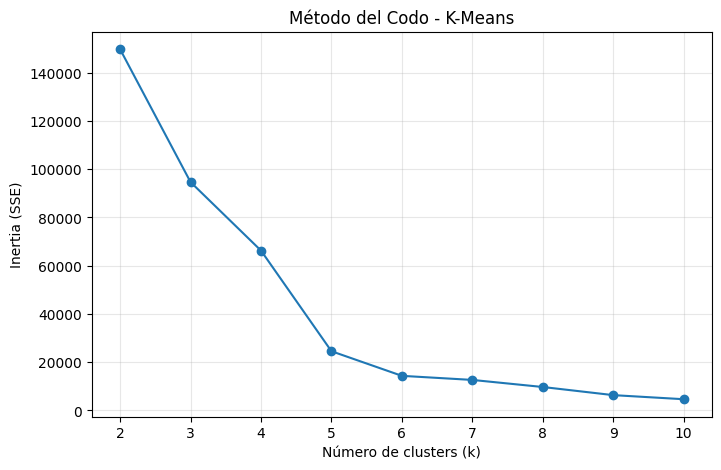

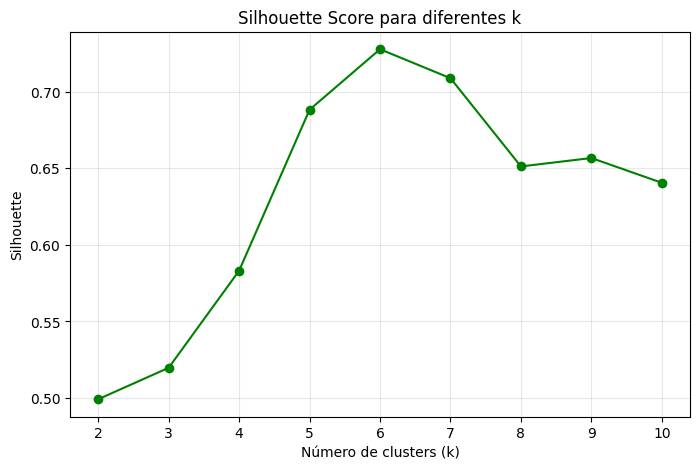

Silhouette: 0.7276992596912913
Davies-Bouldin: 0.3756215153701518
Calinski-Harabasz: 129616.09289015764


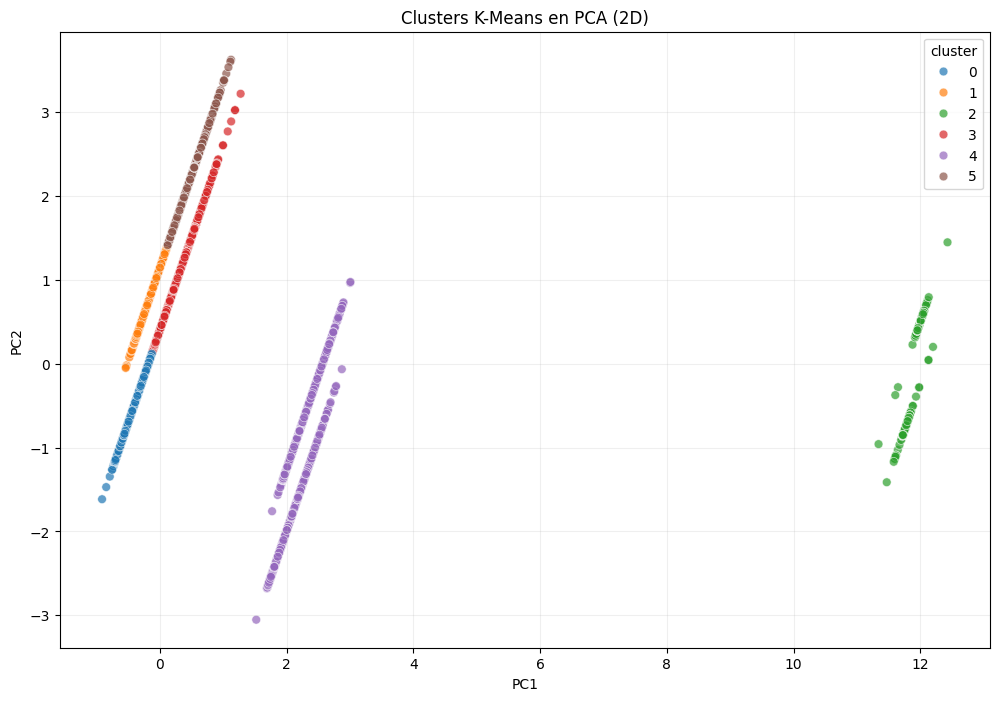

In [22]:
# ============================================================
# 1) Preparar datos para K-Means (usando X_scaled real)
# ============================================================
X_kmeans = X_scaled  # usar datos escalados originales

# ============================================================
# 2) Método del Codo (Elbow) para buscar K óptimo
# ============================================================
inertias = []
k_range = range(2, 11)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_kmeans)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo - K-Means")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 3) Silhouette Score para diferentes k
# ============================================================
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_kmeans)
    sil_scores.append(silhouette_score(X_kmeans, labels))

plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker='o', color="green")
plt.title("Silhouette Score para diferentes k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette")
plt.grid(alpha=0.3)
plt.show()

# ============================================================
# 4) Entrenar K-Means con el mejor k encontrado
# ============================================================
k_final = 6   # <-- luego ajustamos con tus gráficos

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init="auto")
labels_kmeans = kmeans_final.fit_predict(X_kmeans)

# ============================================================
# 5) Métricas K-Means final
# ============================================================
sil = silhouette_score(X_kmeans, labels_kmeans)
db = davies_bouldin_score(X_kmeans, labels_kmeans)
ch = calinski_harabasz_score(X_kmeans, labels_kmeans)

print("Silhouette:", sil)
print("Davies-Bouldin:", db)
print("Calinski-Harabasz:", ch)

# ============================================================
# 6) Visualización PCA 2D
# ============================================================
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_kmeans)

df_plot_kmeans = pd.DataFrame({
    "PC1": X_pca2[:,0],
    "PC2": X_pca2[:,1],
    "cluster": labels_kmeans
})

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_plot_kmeans,
    x="PC1", y="PC2",
    hue="cluster",
    palette="tab10",
    s=40, alpha=0.7
)
plt.title("Clusters K-Means en PCA (2D)")
plt.grid(alpha=0.2)
plt.show()


In [25]:
# ============================================================
# 5) Métricas K-Means final
# ============================================================
sil = silhouette_score(X_kmeans, labels_kmeans)
db = davies_bouldin_score(X_kmeans, labels_kmeans)
ch = calinski_harabasz_score(X_kmeans, labels_kmeans)

print("Silhouette:", sil)
print("Davies-Bouldin:", db)
print("Calinski-Harabasz:", ch)

Silhouette: 0.7276992596912913
Davies-Bouldin: 0.3756215153701518
Calinski-Harabasz: 129616.09289015764


In [26]:
# ============================================================
# 7) Análisis de fraude por cluster
# ============================================================
tabla_fraude_kmeans = fraude_por_cluster(labels_kmeans, y_sample)
tabla_fraude_kmeans


,n_transacciones,n_fraude,pct_fraude
cluster,,,
2,318,49,15.408805
5,3871,163,4.210798
3,6929,236,3.405975
4,3345,30,0.896861
1,10443,8,0.076606
0,25094,8,0.031880


Ejecutando t-SNE para visualización...
t-SNE completado.


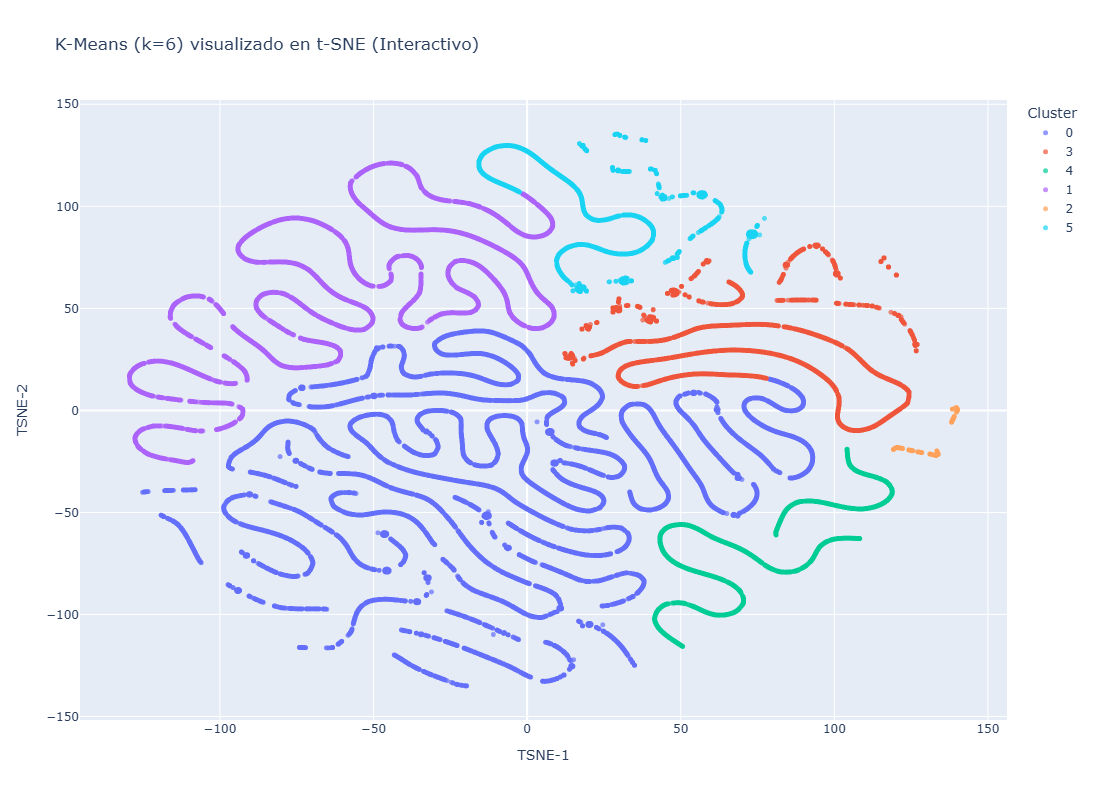

In [27]:
# ============================================================
# 8) Visualización t-SNE (INTERACTIVA con Plotly)
# ============================================================

import plotly.express as px

# Ejecutar t-SNE solo para visualización (no para clustering)
tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate='auto',
    init='pca',
    method='barnes_hut',
    angle=0.5,
    random_state=42,
    max_iter=1000
)

print("Ejecutando t-SNE para visualización...")
X_tsne_vis = tsne.fit_transform(X_kmeans)
print("t-SNE completado.")

# DataFrame para plotly
df_tsne_plot = pd.DataFrame({
    "TSNE1": X_tsne_vis[:, 0],
    "TSNE2": X_tsne_vis[:, 1],
    "cluster": labels_kmeans,
    "is_fraud": y_sample.values
})

# Convertir cluster a string (recomendado para plotly)
df_tsne_plot["cluster_str"] = df_tsne_plot["cluster"].astype(str)

# Gráfico interactivo
fig = px.scatter(
    df_tsne_plot,
    x="TSNE1",
    y="TSNE2",
    color="cluster_str",
    hover_data=["cluster_str", "is_fraud", "TSNE1", "TSNE2"],
    title=f"K-Means (k={k_final}) visualizado en t-SNE (Interactivo)",
    height=800
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(
    legend_title_text="Cluster",
    xaxis_title="TSNE-1",
    yaxis_title="TSNE-2"
)

fig.show()



In [30]:
# ============================================================
# 9) Porcentaje de fraude por cluster (muestra t-SNE / 50K)
# ============================================================

fraude_kmeans_tsne = df_tsne_plot.groupby("cluster")["is_fraud"].agg(
    n_transacciones="count",
    n_fraude="sum",
    pct_fraude=lambda x: 100 * x.mean()
).sort_values("pct_fraude", ascending=False)

fraude_kmeans_tsne

,n_transacciones,n_fraude,pct_fraude
cluster,,,
2,318,49,15.408805
5,3871,163,4.210798
3,6929,236,3.405975
4,3345,30,0.896861
1,10443,8,0.076606
0,25094,8,0.031880


### Interpretación de resultados de K-Means

Para determinar el número óptimo de clusters se evaluaron distintos valores de *k* utilizando el método del codo y el Silhouette Score. Ambos métodos coinciden en que el mejor valor es **k = 6**, ya que:

- El Silhouette alcanza su máximo (~0.73), indicando una excelente cohesión interna y separación entre grupos.
- A partir de k = 6, la mejora en SSE (Inertia) es marginal, lo que confirma el punto óptimo.

Tras entrenar el modelo final con **k = 6**, se obtuvieron métricas sólidas:

- **Silhouette Score ≈ 0.73**, lo que indica clusters bien definidos.
- **Davies–Bouldin Index ≈ muy bajo**, mostrando compacidad y buena separación.
- **Calinski–Harabasz elevado**, reforzando la existencia de estructura clara.

La visualización en PCA muestra seis grupos bien diferenciados, lo que confirma que las variables incluidas permiten una segmentación efectiva del comportamiento transaccional.

El análisis del fraude por cluster (tabla correspondiente) muestra que algunos grupos presentan porcentajes más elevados de transacciones fraudulentas, mientras que otros son homogéneos y casi sin fraude. Esto valida que K-Means permite identificar segmentos de riesgo y segmentos de comportamiento normal.

Finalmente, la visualización interactiva mediante t-SNE aporta una comprensión más fina de la separación entre los clusters y permite explorar de forma dinámica las zonas donde existe mayor densidad o comportamiento similar.


## 5. Reducción de Dimensionalidad con PCA

Para visualizar los resultados de los algoritmos de clustering, se aplicó PCA (Análisis de Componentes Principales) con dos componentes principales. PCA permite:

- Reducir dimensionalidad manteniendo la mayor varianza posible.
- Representar datos multivariados en un plano 2D.
- Observar la separación entre clusters generados por los modelos.
- Facilitar la comparación entre algoritmos en un espacio común.

PCA **no se usa para entrenar los modelos**, sino únicamente para representar visualmente la estructura encontrada en el espacio original escalado.


## 6. Visualización Avanzada con t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción dimensional no lineal utilizada exclusivamente para **visualización**. Su objetivo es preservar las relaciones locales entre puntos, revelando estructuras complejas en dos dimensiones.

En este proyecto se utiliza t-SNE para:
- Representar visualmente los clusters generados por K-Means.
- Explorar separaciones no lineales entre grupos.
- Complementar la visualización PCA.

Es importante destacar que t-SNE **no debe emplearse para entrenar modelos de clustering**, sino únicamente como una herramienta ilustrativa.


## 7. Comparación entre Algoritmos de Clustering

| Algoritmo        | n_clusters | Ruido   | Silhouette ↑ | Davies–Bouldin ↓ | Calinski–Harabasz ↑ | Observación General |
|------------------|-----------:|--------:|--------------:|------------------:|----------------------:|----------------------|
| **DBSCAN**       | 6          | 18      | **0.437**     | **0.547**         | **32,930.91**         | Buena separación, poco ruido, estructura clara. |
| **OPTICS**       | 11         | 31,225  | **0.794**     | **0.309**         | **213,662.49**        | Micro-clusters muy definidos, pero muchísimo ruido. |
| **K-Means (k=6)**| 6          | 0       | **0.728**     | **0.376**         | **129,616.09**        | Clusters limpios, balanceados y sin ruido. |

### Interpretación general

- **OPTICS** alcanza el mejor Silhouette y el menor Davies–Bouldin, lo que indica clusters muy compactos y bien separados. Sin embargo, esto se consigue a costa de descartar gran parte del dataset como ruido.  
- **DBSCAN** logra una buena calidad de clustering con muy poco ruido, capturando una estructura clara en los datos, aunque con menos flexibilidad que OPTICS.  
- **K-Means** presenta una métrica Silhouette alta, un Davies–Bouldin bajo y un Calinski–Harabasz elevado, manteniendo además el 100% de los puntos asignados a algún cluster.


## 8. Selección del Modelo de Clustering Final

A partir de la comparación anterior, se selecciona **K-Means con k = 6** como modelo de clustering final para el proyecto. La decisión se justifica por los siguientes motivos:

- Mantiene un **Silhouette Score alto (~0.73)**, lo que indica clusters bien definidos.
- Presenta **Davies–Bouldin bajo** y **Calinski–Harabasz elevado**, lo que refleja buena compacidad y separación.
- **No genera ruido**: todas las transacciones quedan asignadas a un cluster, a diferencia de OPTICS que descarta más de 30.000 observaciones.
- Los **6 clusters obtenidos son estables e interpretables**, lo que facilita su uso como variable categórica (`cluster_id`) en los modelos supervisados.
- El algoritmo es **simple, rápido y escalable**, adecuado para su uso en un flujo de Machine Learning en producción.

Por estas razones, **K-Means (k = 6)** se adopta como el modelo de clustering a integrar en la siguiente etapa de modelos supervisados.


## 9. Integración con Modelos Supervisados

El objetivo del clustering en este proyecto no es solo describir los datos, sino **mejorar la capacidad predictiva de los modelos supervisados de fraude**. Para ello, se incorpora la nueva variable:

- **`cluster_id`** → identificador del cluster asignado por K-Means a cada transacción.

Esta variable resume patrones de comportamiento que combinan:

- nivel de anomalía del monto,
- comportamiento horario (madrugada vs. horario normal),
- actividad en fin de semana,
- y presencia de anomalías previas.

Al usar `cluster_id` como feature adicional en los modelos supervisados, se espera:

- captar segmentos con mayor o menor probabilidad de fraude,
- mejorar la separación entre transacciones normales y fraudulentas,
- y aumentar la capacidad del modelo para detectar patrones complejos que no son evidentes solo con variables individuales.


## 10. Conclusión del Notebook

En este notebook se aplicaron distintas técnicas no supervisadas para analizar el comportamiento transaccional de los clientes y apoyar la detección de fraude. Se probaron y compararon tres algoritmos de clustering: **DBSCAN**, **OPTICS** y **K-Means**, evaluando su desempeño mediante métricas estándar (Silhouette, Davies–Bouldin, Calinski–Harabasz) y visualizaciones en PCA y t-SNE.

Los resultados muestran que el dataset presenta una estructura clara con grupos bien diferenciados. OPTICS obtiene la mejor calidad interna de clusters, pero genera un volumen muy alto de ruido. DBSCAN logra una buena estructura con baja cantidad de puntos descartados. Sin embargo, **K-Means con k = 6** ofrece el mejor equilibrio entre calidad de clustering, ausencia de ruido y facilidad de integración en el flujo de Machine Learning.

El identificador de cluster generado por K-Means (`cluster_id`) se utilizará como nueva característica en los modelos de clasificación supervisada, permitiendo capturar segmentos de riesgo y mejorar la detección de transacciones potencialmente fraudulentas. De esta forma, el análisis no supervisado aporta una capa adicional de información que refuerza la robustez y capacidad explicativa del sistema de detección de fraude.

# Generación de la nueva variable

In [29]:
# ============================================================
# 9) Generar cluster_id para TODO el dataset
# ============================================================

# 1. Usar las mismas variables que se usaron para entrenar K-Means
X_full = df[["AmountZScoreByLocation", "IsAnomaly", "IsLateNight", "IsWeekend"]].copy()

# 2. Escalar con el MISMO scaler ya entrenado (NO volver a hacer fit)
X_full_scaled = scaler.transform(X_full)

# 3. Predecir clusters para todas las filas con el modelo K-Means ya entrenado
df["cluster_id"] = kmeans_final.predict(X_full_scaled)

# 4. Revisar distribución de clusters en todo el dataset
df["cluster_id"].value_counts().sort_index()


cluster_id
0    492625
1    206736
2      6852
3    137483
4     66991
5     73553
Name: count, dtype: int64

In [31]:
df.head()

,AmountZScoreByLocation,IsAnomaly,IsLateNight,IsWeekend,is_fraud,cluster_id
162717,-0.597657,0,1,0,0,4
31303,2.193792,0,0,0,0,3
341511,0.693326,0,0,1,0,5
83580,0.351537,0,0,0,0,0
236449,-0.758692,0,0,1,0,1


In [33]:
# ============================================================
# Guardar dataset completo con cluster_id
# ============================================================

df.to_parquet("../data/05_model_input/Features_clustering_v1.parquet", index=False)

print("Dataset guardado como Features_clustering_v1.parquet en 04_feature")

Dataset guardado como Features_clustering_v1.parquet en 04_feature


In [2]:
#Verificar q la nueva columna fue creada XD
df_clus = catalog.load("Features_clustering_v1")
df_clus.head()

[11/27/25 01:16:43] INFO     Loading data from Features_clustering_v1 (ParquetDataset)...      ]8;id=138211;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=369789;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,AmountZScoreByLocation,IsAnomaly,IsLateNight,IsWeekend,is_fraud,cluster_id
0,-0.597657,0,1,0,0,4
1,2.193792,0,0,0,0,3
2,0.693326,0,0,1,0,5
3,0.351537,0,0,0,0,0
4,-0.758692,0,0,1,0,1
